In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch.nn import MSELoss
from torchmetrics import ConfusionMatrix,F1Score
import torch.nn.functional as F
import torchmetrics
from torchmetrics import MeanSquaredError,PearsonCorrCoef
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

Looking in links: file:///kaggle/input/torch-geometric


In [16]:
dataset=Planetoid(root='Cora',name='Cora')

In [17]:
print("Dataset size:",len(dataset))
print("Number of classes:",dataset.num_classes)
print("Number of node features:",dataset.num_features)
print("Graphs undirected:",dataset[0].is_undirected())

Dataset size: 1
Number of classes: 7
Number of node features: 1433
Graphs undirected: True


In [18]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,p=0.5, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=5e-4)

model.train()
losses=[]
test_losses=[]
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
    test_losses.append(test_loss.item())

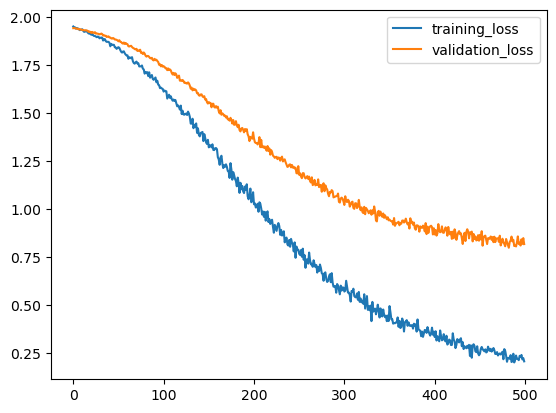

In [20]:
plt.plot(losses,label="training_loss")
plt.plot(test_losses,label="validation_loss")
plt.legend()

Accuracy: 0.8050
f1_score: 0.8050000071525574


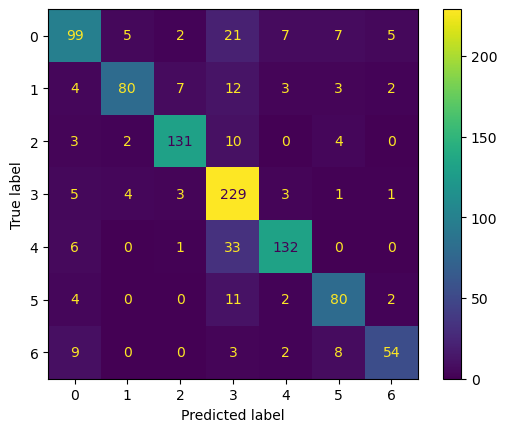

In [21]:
conf_mat=ConfusionMatrix(task="multiclass",num_classes=7).to(device)
f1=F1Score(task="multiclass",num_classes=7).to(device)
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')
confMat=conf_mat(pred[data.test_mask],data.y[data.test_mask])
f1_score=f1(pred[data.test_mask],data.y[data.test_mask])
print("f1_score:",f1_score.item())
ConfusionMatrixDisplay.from_predictions(pred[data.test_mask].cpu(),data.y[data.test_mask].cpu())